## Introduction
In this notebook you will create the dataset class used to feed slices and corresponding segmentation masks to the network during training.
It is similar to the CardiacDataset

In [25]:
from pathlib import Path
import numpy as np
import torch
from torch.utils.data import Dataset
import imgaug.augmenters as iaa
from imgaug.augmentables.segmaps import SegmentationMapsOnImage

## LungDataset

To train our segmentation model, we need a way to efficiently load pairs of 2D CT slices and their corresponding tumor masks. PyTorch provides a base class `Dataset` that we can extend to create a custom loader for our preprocessed `.npy` slices.

Each subject folder contains two subfolders:
- `data/` with normalized 2D CT slices
- `masks/` with binary tumor masks of the same size

The `LungDataset` class handles:
- Locating all slice paths
- Matching each slice to its corresponding mask
- Optional data augmentation
- Balanced sampling of tumor vs. non-tumor slices

---

### Class Methods (Overview)

#### `__init__(self, root, augment_params=None, tumor_oversampling_factor=20)`
Initializes the dataset:
- Scans all slice files under `root`
- Optionally stores an augmentation pipeline
- Computes sampling weights to favor slices with tumor (if desired)

#### `extract_files(root)`
Returns a list of paths to all `.npy` slices found in `*/data/`.

#### `_precompute_weights()`
Assigns a higher sampling weight to slices containing tumor to mitigate class imbalance.

#### `change_img_to_label_path(path)`
Given a slice path (e.g. `.../data/45.npy`), returns the corresponding mask path (e.g. `.../masks/45.npy`).

#### `augment(self, slice, mask)`
Applies consistent random augmentations to both the slice and mask using the configured transformation pipeline.

#### `__len__(self)`
Returns the total number of slices available in the dataset.

#### `__getitem__(self, idx)`
Loads one image-mask pair:
- Reads `.npy` files
- Applies augmentations (if enabled)
- Adds channel dimension to get shape `(1, 256, 256)`
- Returns a tuple `(image, mask)`, ready for batching in PyTorch

---

This dataset class enables efficient 2D slice loading for training and validation, and integrates seamlessly with PyTorch's `DataLoader`.


In [33]:
class LungDataset(torch.utils.data.Dataset):
    def __init__(self, root, augment_params=None, tumor_oversampling_factor=20):
        # Collect all image slice paths from the dataset root
        self.all_files = self.extract_files(root)
        
        # Store optional augmentation function
        self.augment_params = augment_params
        
        # Weight for slices that contain tumor (used for oversampling)
        self.tumor_oversampling_factor = tumor_oversampling_factor
        
        # Precompute weights based on presence of tumor
        self._precompute_weights()

    @staticmethod
    def extract_files(root):
        """Collects all slice paths inside '*/data/*.npy' folders"""
        files = []
        for subject in root.glob("*"):
            slice_path = subject / "data"
            for slice_file in slice_path.glob("*"):
                files.append(slice_file)
        return files

    def _precompute_weights(self):
        """Assigns higher weight to slices that contain tumor"""
        self.weights = []
        for file_path in self.all_files:
            mask_path = self.change_img_to_label_path(file_path)
            mask = np.load(mask_path)
            if np.any(mask):
                self.weights.append(self.tumor_oversampling_factor)
            else:
                self.weights.append(1)

    @staticmethod
    def change_img_to_label_path(path):
        """Replaces 'data' with 'masks' in the path to get the label path"""
        parts = list(path.parts)
        parts[parts.index("data")] = "masks"
        return Path(*parts)

    def augment(self, slice, mask):
        """Applies random augmentations to the image and mask"""
        random_seed = torch.randint(0, 1000000, (1,)).item()
        np.random.seed(random_seed)  # Ensure both are augmented equally
        
        # Convert mask to imgaug format
        mask = SegmentationMapsOnImage(mask, mask.shape)
        
        # Apply augmentations
        slice_aug, mask_aug = self.augment_params(
            image=slice,
            segmentation_maps=mask
        )
        return slice_aug, mask_aug.get_arr()

    def __len__(self):
        """Returns the number of slices"""
        return len(self.all_files)

    def __getitem__(self, idx):
        """Returns one slice-mask pair"""
        file_path = self.all_files[idx]
        mask_path = self.change_img_to_label_path(file_path)

        # Load image and mask from .npy files
        slice = np.load(file_path).astype(np.float32)
        mask = np.load(mask_path).astype(np.uint8)

        # Apply augmentations if configured
        if self.augment_params:
            slice, mask = self.augment(slice, mask)
            slice = np.clip(slice, 0, 1)

        # Add channel dimension: (1, H, W)
        return (
            np.expand_dims(slice, 0),
            np.expand_dims(mask, 0)
        )

## Augmentation and Dataset Initialization

We define a simple augmentation pipeline using `imgaug`, including affine transformations such as zooming, rotating, and elastic deformations. These help the model generalize better by introducing variability.

Then, we instantiate two datasets:
- `train_dataset` with augmentations applied
- `val_dataset` without augmentations (for validation consistency)

To deal with class imbalance (many slices contain no tumor), we use a `WeightedRandomSampler`. This ensures that slices with tumors are sampled more frequently during training, according to their precomputed weights.

In [27]:
seq = iaa.Sequential([
    iaa.Affine(scale=(0.85, 1.15), # zoom in or out
               rotate=(-45, 45)),  # rotate up to 45 degrees
    iaa.ElasticTransformation()
                ])

In [28]:
path = Path("../datos/Preprocessed/train/")
path_val = Path("../datos/Preprocessed/val/")
train_dataset = LungDataset(path, augment_params=seq)
val_dataset = LungDataset(path_val, augment_params=None)

sampler = torch.utils.data.WeightedRandomSampler(
    weights=train_dataset.weights,
    num_samples=len(train_dataset),
    replacement=True
)

## Sample Inspection and Augmentation Visualization

Before training, it's useful to manually inspect how our dataset behaves and verify that everything is working as expected.

This cell:
- Loads the dataset from the preprocessed slices
- Finds the first slice that contains a tumor based on the sampling weights
- Visualizes a sample slice and its corresponding mask
- Applies augmentations multiple times to the same slice to confirm variability and check consistency

This helps ensure that:
- The dataset is correctly structured
- Shapes, dtypes, and value ranges are valid
- Augmentations preserve the tumor structure and output valid masks


Slice con tumor encontrada en índice 115
Total de slices cargados: 14484
=== Verificación Inicial ===
Slice - Shape: (1, 256, 256), dtype: float32, range: [0.0, 1.0]
Mask - Shape: (1, 256, 256), dtype: uint8, unique: [0 1]


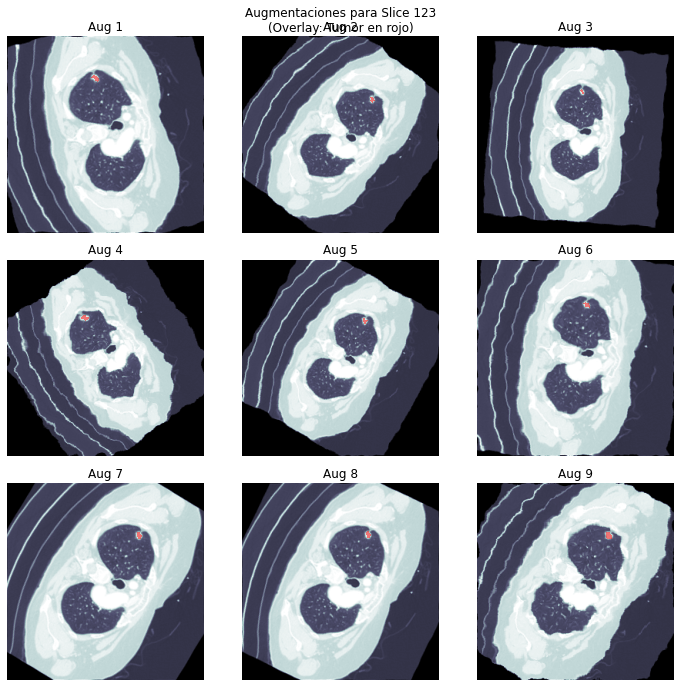

In [34]:
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np

# Load the dataset from the preprocessed training path
dataset = LungDataset(
    root=Path("../datos/Preprocessed/train/"),
    augment_params=seq  # 'seq' is the augmentation pipeline (e.g. imgaug)
)

# Find the first index with a tumor (i.e. weight > 1)
for idx, weight in enumerate(dataset.weights):
    if weight > 1:
        print(f"Tumor slice found at index {idx}")
        break

# Load a specific slice (adjust index as needed)
sample_idx = 123  # You may change this if the slice is empty

# Load the slice and mask (no augmentation yet)
slice, mask = dataset[sample_idx]
print(f"Total number of slices: {len(dataset)}")

# Print shape and value info before augmentation
print("=== Initial Verification ===")
print(f"Slice - Shape: {slice.shape}, dtype: {slice.dtype}, range: [{slice.min()}, {slice.max()}]")
print(f"Mask  - Shape: {mask.shape}, dtype: {mask.dtype}, unique: {np.unique(mask)}")

# Visualize several augmentations of the same slice
fig, axes = plt.subplots(3, 3, figsize=(10, 10))

for i in range(3):
    for j in range(3):
        # Each call to dataset[] returns a different augmentation
        slice_aug, mask_aug = dataset[sample_idx]

        # Basic checks after augmentation
        assert slice_aug.shape == (1, 256, 256), f"Invalid slice shape: {slice_aug.shape}"
        assert mask_aug.shape == (1, 256, 256), f"Invalid mask shape: {mask_aug.shape}"
        assert np.array_equal(np.unique(mask_aug), np.array([0, 1])), "Mask is not binary"

        # Display slice with overlay
        axes[i, j].imshow(slice_aug[0], cmap="bone")
        overlay = np.ma.masked_where(mask_aug[0] == 0, mask_aug[0])
        axes[i, j].imshow(overlay, cmap="autumn", alpha=0.5)
        axes[i, j].axis("off")
        axes[i, j].set_title(f"Aug {i*3 + j + 1}")

plt.suptitle(f"Augmentations for Slice {sample_idx} (Red overlay = tumor)", y=0.95)
plt.tight_layout()
plt.show()
